In [1]:
import numpy as np
import pandas as pd
from keras import models, layers

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import json
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
training_data_path = '../data/datasets/training_data_noisy_small_track_symetric_delayed_deviation.csv'
df = pd.read_csv(training_data_path)
print(f'{df.shape=}')
df.sample(5)

df.shape=(23760, 19)


,steering_angle,waypoint1_lat,waypoint1_lon,waypoint2_lat,waypoint2_lon,waypoint3_lat,waypoint3_lon,waypoint4_lat,waypoint4_lon,waypoint5_lat,waypoint5_lon,waypoint6_lat,waypoint6_lon,waypoint7_lat,waypoint7_lon,waypoint8_lat,waypoint8_lon,waypoint9_lat,waypoint9_lon
13074,-0.200000,-2.215055,-3.023584,-4.546216,-4.858394,-6.508529,-6.966398,-7.371747,-10.942936,-8.636933,-14.413609,-10.579147,-17.424533,-12.239598,-19.940094,-13.661167,-23.913851,-14.254848,-26.134281
11381,0.362932,-0.804473,-2.742546,0.794871,-5.742835,2.394196,-8.743058,3.920043,-11.621222,4.515829,-13.855609,3.705594,-15.771499,1.681928,-17.310479,-1.148939,-18.189922,-4.504644,-18.829478
13567,0.000000,-2.145937,-4.455050,-3.409508,-6.958836,-5.559416,-10.892878,-4.998592,-12.410452,-2.659352,-15.425634,0.739183,-17.615469,4.233054,-17.839055,7.634737,-18.526383,11.196698,-19.586382
4343,-0.000000,1.740688,-2.516444,3.353393,-5.508629,4.952736,-8.508916,6.552084,-11.509199,8.151416,-14.509458,9.718060,-17.525880,10.298289,-20.826729,8.767448,-23.794966,5.980429,-25.694057
14666,-0.300000,2.716624,2.350717,2.999679,7.035013,3.035214,9.358197,3.743440,12.347011,3.500528,16.050876,4.405097,19.544516,4.760557,23.277654,5.945390,25.914521,5.821289,29.244433


In [3]:
X = df.drop(columns=['steering_angle'])
y = df['steering_angle']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19008, 18), (4752, 18), (19008,), (4752,))

In [4]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from datetime import datetime
from keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, Flatten, Reshape, Add
from keras.models import Model
import tensorflow as tf
from keras.losses import Huber
from keras.callbacks import ReduceLROnPlateau

def get_positional_encoding(seq_len, d_model):
    pos = np.arange(seq_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    angle_rads = pos * angle_rates

    pos_encoding = np.zeros_like(angle_rads)
    pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
    pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])

    return tf.cast(pos_encoding[np.newaxis, ...], dtype=tf.float32)

# Model parameters
seq_len = 9
d_model = 32
num_heads = 2

inputs = Input(shape=(18,))
x = Reshape((9, 2))(inputs)
x = Dense(d_model, kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)

# Add positional encoding
pos_encoding = get_positional_encoding(seq_len, d_model)
x += pos_encoding

# First Transformer block
attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=0.1)(x, x)
x = Add()([x, attn_output])
x = LayerNormalization(epsilon=1e-6)(x)

ffn = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-6))(x)
ffn = Dropout(0.1)(ffn)
ffn = Dense(d_model, kernel_regularizer=tf.keras.regularizers.l2(1e-6))(ffn)
x = Add()([x, ffn])
x = LayerNormalization(epsilon=1e-6)(x)

# Second Transformer block (additional)
attn_output2 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=0.1)(x, x)
x = Add()([x, attn_output2])
x = LayerNormalization(epsilon=1e-6)(x)

ffn2 = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-6))(x)
ffn2 = Dropout(0.1)(ffn2)
ffn2 = Dense(d_model, kernel_regularizer=tf.keras.regularizers.l2(1e-6))(ffn2)
x = Add()([x, ffn2])
x = LayerNormalization(epsilon=1e-6)(x)

# Output head
x = Flatten()(x)
x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-6))(x)
outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)

name = 'transformer_with_positional_encoding'
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
checkpoint = ModelCheckpoint(f'../weights/best_{name}_{timestamp}.h5', monitor='val_loss', save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=5, min_lr=1e-5, verbose=1)

model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=0.1), metrics=['mae'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 18)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 9, 2)         0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 9, 32)        96          ['reshape[0][0]']                
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 9, 32)       0           ['dense[0][0]']                  
 da)                                                                                          

In [5]:
EPOCHS = 100
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=32,
    callbacks=[checkpoint, reduce_lr],
    verbose=1
)

Epoch 1/100
594/594 [==============================] - 8s 10ms/step - loss: 0.0146 - mae: 0.1862 - val_loss: 0.0080 - val_mae: 0.1171 - lr: 0.0010
Epoch 2/100
594/594 [==============================] - 7s 12ms/step - loss: 0.0083 - mae: 0.1200 - val_loss: 0.0067 - val_mae: 0.1042 - lr: 0.0010
Epoch 3/100
594/594 [==============================] - 7s 11ms/step - loss: 0.0067 - mae: 0.1034 - val_loss: 0.0057 - val_mae: 0.0924 - lr: 0.0010
Epoch 4/100
594/594 [==============================] - 7s 11ms/step - loss: 0.0061 - mae: 0.0960 - val_loss: 0.0060 - val_mae: 0.0959 - lr: 0.0010
Epoch 5/100
594/594 [==============================] - 6s 11ms/step - loss: 0.0056 - mae: 0.0903 - val_loss: 0.0044 - val_mae: 0.0764 - lr: 0.0010
Epoch 6/100
594/594 [==============================] - 6s 10ms/step - loss: 0.0052 - mae: 0.0864 - val_loss: 0.0047 - val_mae: 0.0809 - lr: 0.0010
Epoch 7/100
594/594 [==============================] - 5s 9ms/step - loss: 0.0050 - mae: 0.0840 - val_loss: 0.0045 - v

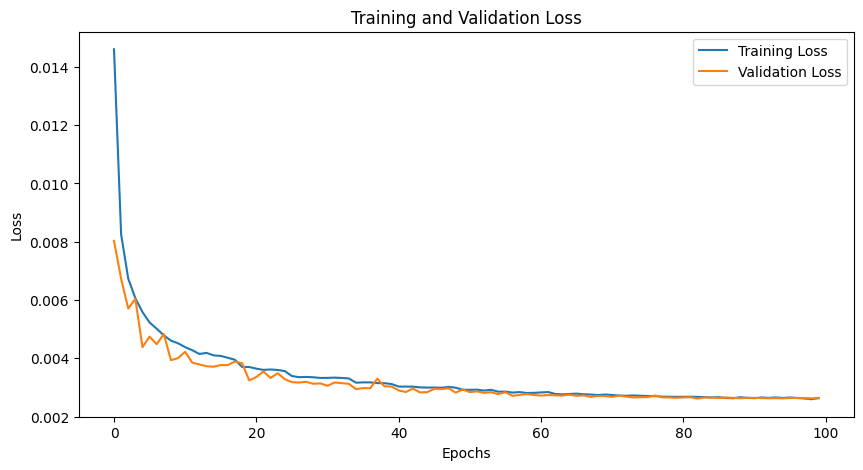

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

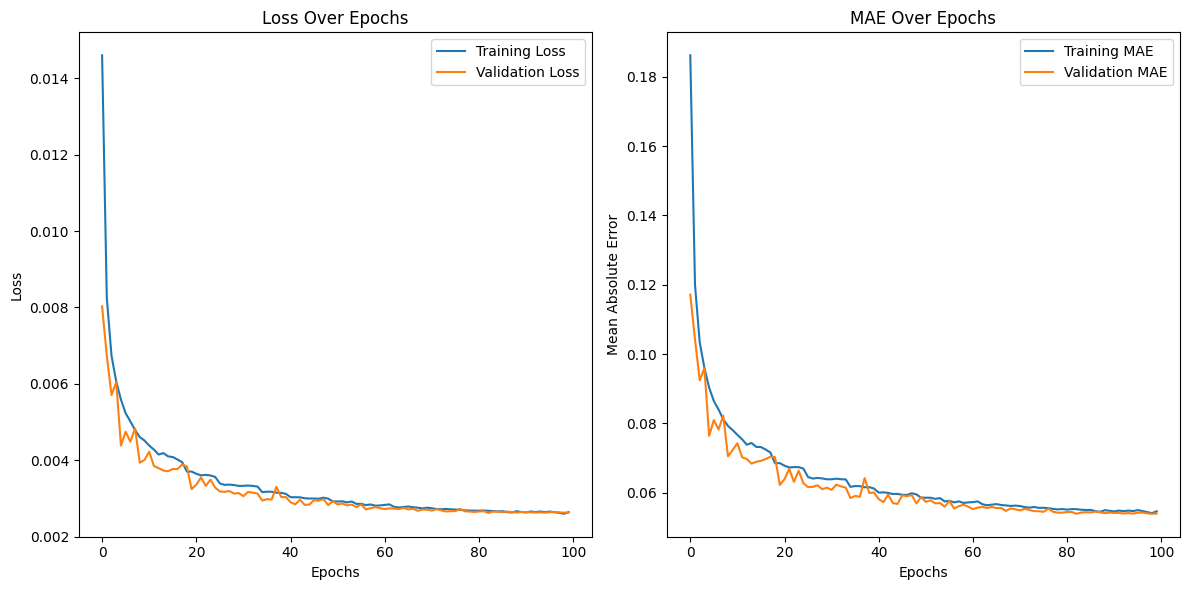

In [7]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('MAE Over Epochs')

plt.tight_layout()
plt.show()

In [8]:
model.load_weights(checkpoint.filepath)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

metrics_df = pd.DataFrame({
    "Metric": ["Mean Squared Error (MSE)", "Mean Absolute Error (MAE)", "R-squared (R2)"],
    "Value": [mse, mae, r2]
})

metrics_df

149/149 [==============================] - 1s 5ms/step


,Metric,Value
0,Mean Squared Error (MSE),0.005321
1,Mean Absolute Error (MAE),0.053899
2,R-squared (R2),0.901660


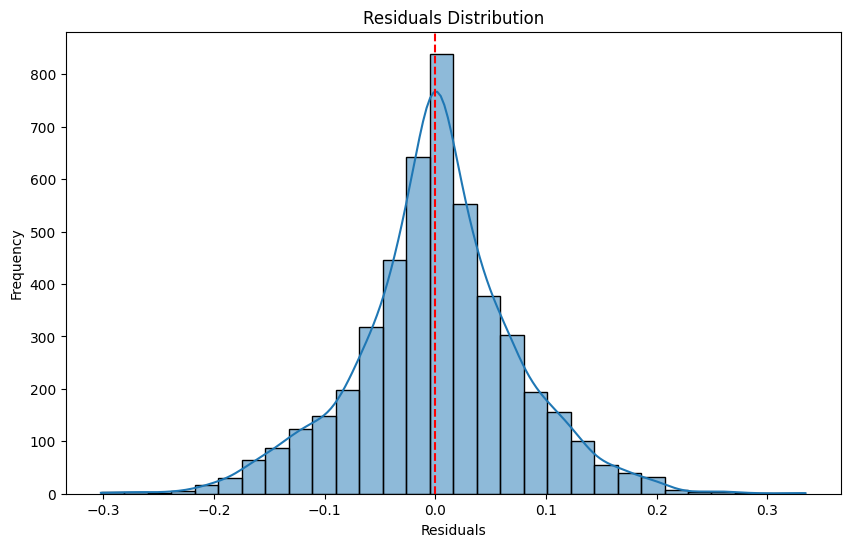

In [9]:
residuals = y_test - y_pred.flatten()
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()

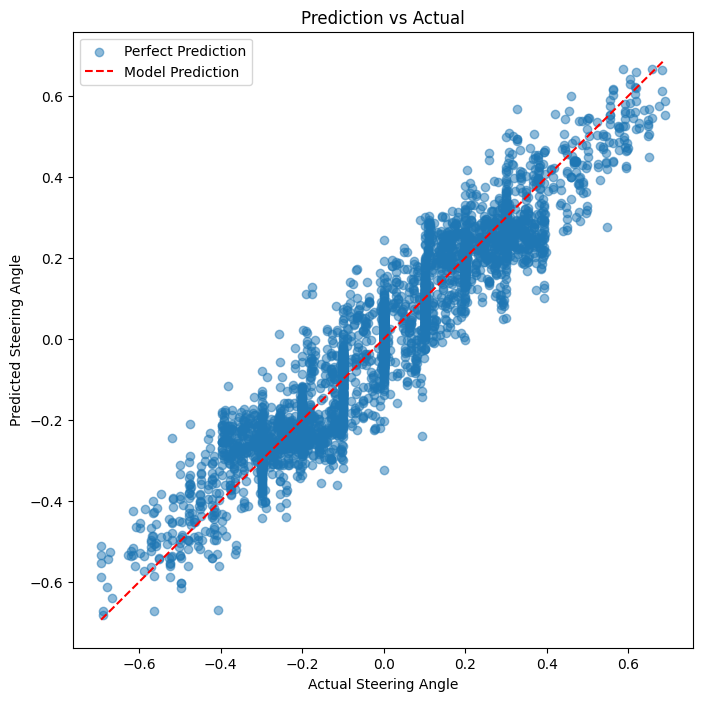

In [10]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Steering Angle')
plt.ylabel('Predicted Steering Angle')
plt.title('Prediction vs Actual')
plt.legend(['Perfect Prediction', 'Model Prediction'])
plt.show()

In [11]:
model_json = model.to_json()
with open(f'../models/{name}.json', 'w') as json_file:
    json.dump(json.loads(model_json), json_file, indent=4)

In [12]:
metadata = {
    "model_name": name,
    "model_path": f"../models/{name}.json",
    "training_data_path": training_data_path,
    "timestamp": timestamp,
    "input_shape": list(X_train.shape[1:]),
    "output_shape": [1],
    "optimizer": {
        "type": "Adam",
        "learning_rate": 0.001
    },
    "loss_function": "mse",
    "metrics": ["mae"],
    "training": {
        "epochs": len(history.history['loss']),
        "batch_size": 32,
        "best_model_path": checkpoint.filepath,
        "final_training_loss": history.history['loss'][-1],
        "final_validation_loss": history.history['val_loss'][-1]
    },
    "evaluation": {
        "mse": mse,
        "mae": mae,
        "r2": r2
    }
}

try:
    with open("metadata.jsonl", "r+") as f:
        lines = f.readlines()
        entry = json.dumps(metadata) + "\n"
        if entry not in lines:
            f.write(entry)
except FileNotFoundError:
    with open("metadata.jsonl", "w") as f:
        f.write(json.dumps(metadata) + "\n")

In [13]:
with open("metadata.jsonl", "r") as f:
    lines = f.readlines()

print(json.dumps(json.loads(lines[-1]), indent=4))

{
    "model_name": "transformer_with_positional_encoding",
    "model_path": "../models/transformer_with_positional_encoding.json",
    "training_data_path": "../data/datasets/training_data_noisy_small_track_symetric_delayed_deviation.csv",
    "timestamp": "20250604_184529",
    "input_shape": [
        18
    ],
    "output_shape": [
        1
    ],
    "optimizer": {
        "type": "Adam",
        "learning_rate": 0.001
    },
    "loss_function": "mse",
    "metrics": [
        "mae"
    ],
    "training": {
        "epochs": 100,
        "batch_size": 32,
        "best_model_path": "../weights/best_transformer_with_positional_encoding_20250604_184529.h5",
        "final_training_loss": 0.0026391837745904922,
        "final_validation_loss": 0.0026284377090632915
    },
    "evaluation": {
        "mse": 0.005320652442524619,
        "mae": 0.05389938807044308,
        "r2": 0.9016600571977922
    }
}
